The goal is to try to do hierarchical clustering of emojis, based on word2vec, ie cosine similarity between word contexts. 

Inspired from data_exploration_dc.ipynb (but no functions so I couldn't import it! ;))

In [3]:
import gensim
from gensim.models import Word2Vec

from data_cleaning_hr import loader
import src.happyfuntokenizing

import pandas as pd
import re

from IPython.display import display

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
import numpy as np
import math

import itertools

import matplotlib.pyplot as plt
%matplotlib inline

## Load files

In [32]:
tweet_df = loader("./data/tweets_training_clean.json")
emojis_df = loader("./data/emoji_webscraped_expanded.json")

## Training word2vec model

When defining the word2vec model, with a window of 5 (default) we are only considering emojis that cooccur close by. Which makes sense. We could even use a smaller window. 

In [16]:
tok = src.happyfuntokenizing.Tokenizer(preserve_case=False)
tweet_df["tokens"] = [list(tok.tokenize(tweet)) for tweet in tweet_df.text]

In [17]:
# To reduce size, train only on tweets with emojis
emoji_model = gensim.models.Word2Vec(list(tweet_df.tokens), window=10) # Does the tokenizer work well on flags? 
# emoji_model.save('emoji.embedding')
emoji_model = gensim.models.Word2Vec.load('emoji.embedding')

In [18]:
emoji_model.most_similar(positive = ['\U0001F601'], negative= [])

[('👍', 0.6583754420280457),
 ('😋', 0.656490683555603),
 ('😆', 0.6184258460998535),
 ('😜', 0.5988847017288208),
 ('😝', 0.5813663005828857),
 ('#whatevs', 0.5766386985778809),
 ('😎', 0.5600958466529846),
 ('😅', 0.5561439394950867),
 ('😄', 0.5554729700088501),
 ('👌', 0.5463070273399353)]

## Hierarchical clustering

In [48]:
# Subsetting to faces
def subset_annotations(df):
    annotations = df.annotations
    list_titles = [list(item) for item in list(annotations)]
    index_face_person = [index for index,value in enumerate(list_titles) if 'face' in value] # or 'person' in value]
    df_face_person = df.iloc[index_face_person]
    return df_face_person

emojis_df = subset_annotations(emojis_df)
print(len(emojis_df))

121


In [57]:
def convertEmojis(df):
    """Converts emojis df to printable format """
    emojis = list(map(lambda x: bytes("{}{}".format(*x), 'ascii').decode('unicode-escape'), zip(list(df.byteCode1), list(df.byteCode2)))) 
    return emojis

In [58]:
# Calculate distances
emojis = convertEmojis(emojis_df)
combinations = itertools.combinations(emojis, 2)

similarities = []
for combination in combinations:
    try:
        similarities += [emoji_model.similarity(*combination)]
    except Exception:
#         similarities += [np.NAN]
        similarities += [0]
similarities = np.array(similarities)

distances = 1 - np.arccos(similarities) / np.pi # From https://en.wikipedia.org/wiki/Cosine_similarity#Angular_similarity

Check if flags are working

#### Using Scipy linkage and dandrogram

In [59]:
hc_linkage = linkage(distances, method="complete")

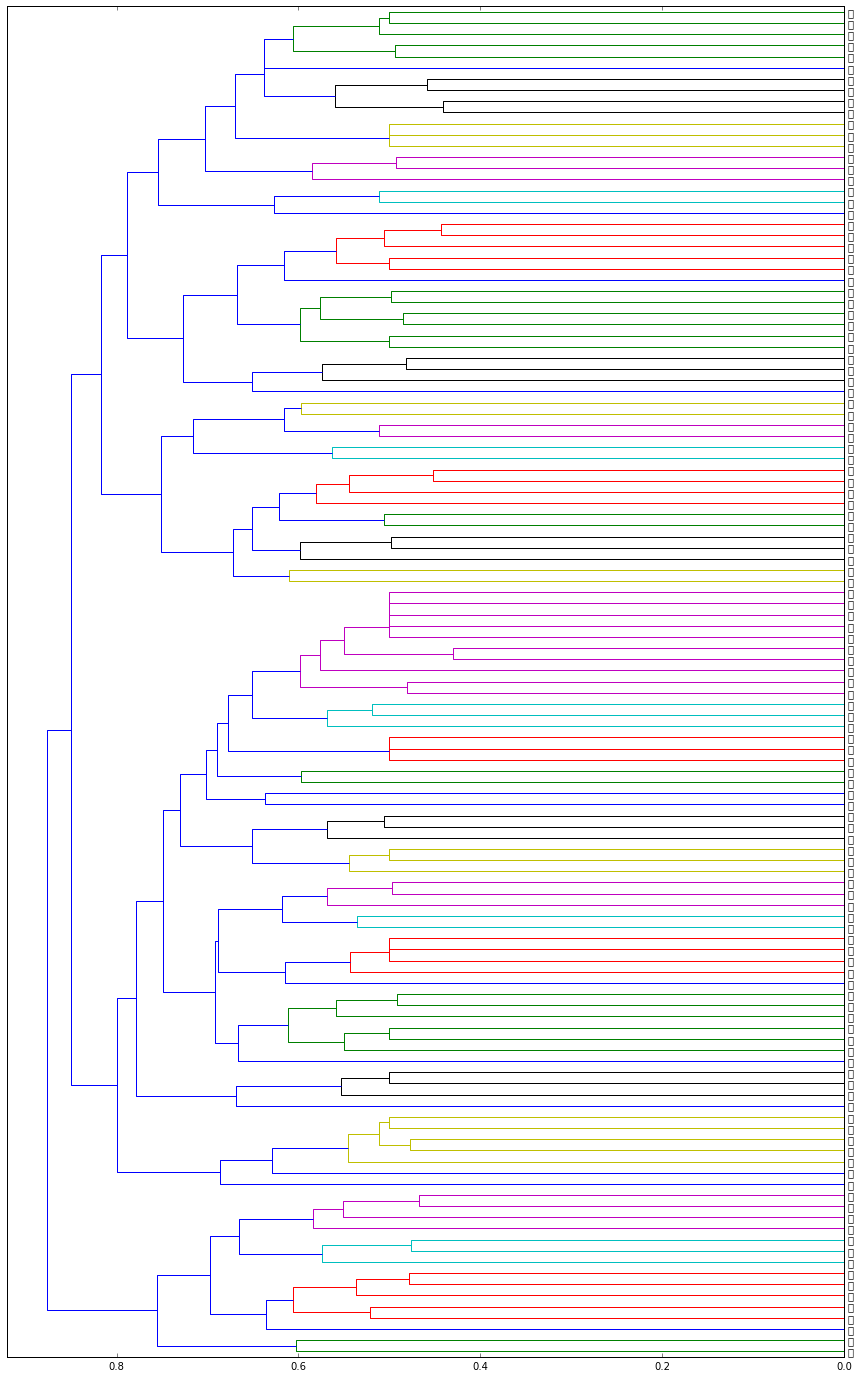

In [60]:
p = 121 # Number of clusters at which to truncate
fig, ax = plt.subplots(figsize=(15, 0.2*p)) # set size
R = dendrogram(hc_linkage, orientation="right", labels=emojis, truncate_mode="lastp", p=p, get_leaves=True, show_leaf_counts=True, show_contracted=False)

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    labelbottom='on')

# plt.tight_layout() #show plot with tight layout
ax.xaxis.grid(True, which='minor')
# ax.set_yticklabels(a.get_yticks(), emoji_font)

In [61]:
from scipy.cluster.hierarchy import fcluster
k=11
categories = fcluster(hc_linkage, k, criterion='maxclust')
emojis_df["category"] = categories

In [62]:
for category in range(1, k+1):
    print("Category {}".format(category))
    emojis_cat = emojis_df[emojis_df["category"] == category]
    for emoji in convertEmojis(emojis_cat):
        print(emoji, end="")
    print("\n")


Category 1
🌛😦

Category 2
😀😑🐷😏🐼😥😛😲🌚😠👽😽🙉

Category 3
☺😂🙄🐸😨☠🙊

Category 4
😚🦄🐭😟

Category 5
👼🙂🐱🐰😮🤓😄😒😢🌝🌬😬😳😵💀🙀😋

Category 6
😁⛑🗣😙🤗🐶😶🦁🐯🐻🐲😃😝🙁😔🤕😅😧😩😡😈🤖💩😸🗿😿

Category 7
😍🐵😞😤🌞😆😰👹👾😼🙈

Category 8
🐮😌😓😱👿😺

Category 9
😎😘👀🐺🐽🐳🤐😯😴😕😖🤑😭😊😹😾

Category 10
🐹😪😜

Category 11
😗😇🤔😐🐴😣😫☹🙃😷🤒🌜😉👺👻😻



In [25]:
for emoji in emojis:
    print(emoji, end="")

😀😁😎👲㊙🈺🈵▪▫◻◼◽◾⬛👳⬜🔶🔷🔸🔹🔺🔻💠🔘🔲👷🔳⚪⚫🔴🔵🇦🇨🇦🇩🇦🇪🇦🇫🇦🇬⛑🇦🇮🇦🇱🇦🇲🇦🇴🇦🇶🇦🇷🇦🇸🇦🇹🇦🇺🇦🇼👸🇦🇽🇦🇿🇧🇦🇧🇧🇧🇩🇧🇪🇧🇫🇧🇬🇧🇭🇧🇮💂🇧🇯🇧🇱🇧🇲🇧🇳🇧🇴🇧🇶🇧🇷🇧🇸🇧🇹🇧🇻🕵🇧🇼🇧🇾🇧🇿🇨🇦🇨🇨🇨🇩🇨🇫🇨🇬🇨🇭🇨🇮🎅🇨🇰🇨🇱🇨🇲🇨🇳🇨🇴🇨🇵🇨🇷🇨🇺🇨🇻🇨🇼👼🇨🇽🇨🇾🇨🇿🇩🇪🇩🇬🇩🇯🇩🇰🇩🇲🇩🇴🇩🇿👯🇪🇦🇪🇨🇪🇪🇪🇬🇪🇭🇪🇷🇪🇸🇪🇹🇪🇺🇫🇮😍💆🇫🇯🇫🇰🇫🇲🇫🇴🇫🇷🇬🇦🇬🇧🇬🇩🇬🇪🇬🇫💇🇬🇬🇬🇭🇬🇮🇬🇱🇬🇲🇬🇳🇬🇵🇬🇶🇬🇷🇬🇸👰🇬🇹🇬🇺🇬🇼🇬🇾🇭🇰🇭🇲🇭🇳🇭🇷🇭🇹🇭🇺🙍🇮🇨🇮🇩🇮🇪🇮🇱🇮🇲🇮🇳🇮🇴🇮🇶🇮🇷🇮🇸🙎🇮🇹🇯🇪🇯🇲🇯🇴🇯🇵🇰🇪🇰🇬🇰🇭🇰🇮🇰🇲🙅🇰🇳🇰🇵🇰🇷🇰🇼🇰🇾🇰🇿🇱🇦🇱🇧🇱🇨🇱🇮🙆🇱🇰🇱🇷🇱🇸🇱🇹🇱🇺🇱🇻🇱🇾🇲🇦🇲🇨🇲🇩💁🇲🇪🇲🇫🇲🇬🇲🇭🇲🇰🇲🇱🇲🇲🇲🇳🇲🇴🇲🇵🙋🇲🇶🇲🇷🇲🇸🇲🇹🇲🇺🇲🇻🇲🇼🇲🇽🇲🇾🇲🇿🙇🇳🇦🇳🇨🇳🇪🇳🇫🇳🇬🇳🇮🇳🇱🇳🇴🇳🇵🇳🇷😘🙌🇳🇺🇳🇿🇴🇲🇵🇦🇵🇪🇵🇫🇵🇬🇵🇭🇵🇰🇵🇱🙏🇵🇲🇵🇳🇵🇷🇵🇸🇵🇹🇵🇼🇵🇾🇶🇦🇷🇪🇷🇴🗣🇷🇸🇷🇺🇷🇼🇸🇦🇸🇧🇸🇨🇸🇩🇸🇪🇸🇬🇸🇭👤🇸🇮🇸🇯🇸🇰🇸🇱🇸🇲🇸🇳🇸🇴🇸🇷🇸🇸🇸🇹👥🇸🇻🇸🇽🇸🇾🇸🇿🇹🇦🇹🇨🇹🇩🇹🇫🇹🇬🇹🇭🚶🇹🇯🇹🇰🇹🇱🇹🇲🇹🇳🇹🇴🇹🇷🇹🇹🇹🇻🇹🇼🏃🇹🇿🇺🇦🇺🇬🇺🇲🇺🇸🇺🇾🇺🇿🇻🇦🇻🇨🇻🇪💃🇻🇬🇻🇮🇻🇳🇻🇺🇼🇫🇼🇸🇽🇰🇾🇪🇾🇹🇿🇦🕴🇿🇲🇿🇼💏😗💑👪👫👬👭🏻🏼🏽🏾🏿😙💪👈👉☝👆🖕👇✌🖖🤘😚🖐✊✋👊👌👍👎👋👏👐☺✍💅👂👃👣👀👁👅👄💋🙂💘❤💓💔💕💖💗💙💚💛🤗💜💝💞💟❣💌💤💢💣💥😇💦💨💫💬🗨🗯💭🕳👓🕶😂🤔👔👕👖👗👘👙👚👛👜👝😐🛍🎒👞👟👠👡👢👑👒🎩😑🎓📿💄💍💎🐵🐒🐶🐕🐩😶🐺🐱🐈🦁🐯🐅🐆🐴🐎🦄🙄🐮🐂🐃🐄🐷🐖🐗🐽🐏🐑😏🐐🐪🐫🐘🐭🐁🐀🐹🐰🐇😣🐿🐻🐨🐼🐾🦃🐔🐓🐣🐤😥🐥🐦🐧🕊🐸🐊🐢🐍🐲🐉😮🐳🐋🐬🐟🐠🐡🐙🐚🦀🐌🤐🐛🐜🐝🐞🕷🕸🦂💐🌸💮😃😯🏵🌹🌺🌻🌼🌷☘🌱🌲🌳😪🌴🌵🌾🌿🍀🍁🍂🍃🍇🍈😫🍉🍊🍋🍌🍍🍎🍏🍐🍑🍒😴🍓🍅🍆🌽🌶🍄🌰🍞🧀🍖😌🍗🍔🍟🍕🌭🌮🌯🍿🍲🍱🤓🍘🍙🍚🍛🍜🍝🍠🍢🍣🍤😛🍥🍡🍦🍧🍨🍩🍪🎂🍰🍫😜🍬🍭🍮🍯🍼☕🍵🍶🍾🍷😝🍸🍹🍺🍻🍽🍴🍳🏺🌍🌎☹🌏🌐🗺🏔⛰🌋🗻🏕🏖🏜😄🙁🏝🏞🏟🏛🏗🏘🏙🏚🏠🏡😒⛪🕋🕌🕍⛩🏢🏣🏤🏥🏦😓🏨🏩🏪🏫🏬🏭🏯🏰💒🗼😔🗽🗾⛲⛺🌁🌃🌄🌅🌆🌇😕🌉♨🌌🎠🎡🎢💈🎪🎭🖼😖🎨🎰🚂🚃🚄🚅🚆🚇🚈🚉🙃🚊🚝🚞🚋🚌🚍🚎🚏🚐🚑😷🚒🚓🚔🚕🚖🚗🚘🚙🚚🚛🤒🚜🚲⛽🛣🛤🚨🚥🚦🚧⚓🤕⛵🚣🚤🛳⛴🛥🚢✈🛩🛫😅🤑🛬💺🚁🚟🚠🚡🚀🛰🛎🚪😲🛌🛏🛋

In [ ]:
#### Using AgglomerativeClustering

#"while the training objective of the skipgram model is to learn word-vector representations that are good at predicting its context in the same sentence" from http://www.yseam.com/blog/WV.html

# Convert array to 2D matrix
n_emojis = len(emojis_df)
weights_m = np.zeros((n_emojis, n_emojis))
weights_m[np.triu_indices(n_emojis)] = weights
weights_m = weights_m + np.transpose(weights_m) - np.diag(weights_m.diagonal())

hc_model = AgglomerativeClustering(affinity="precomputed", linkage="complete").fit(weights_m)